## Goal: align `gpudrive` with `waymax`

- Using the same scenario (`2bd577a009790706`)

### The following features need to be aligned:

**Agents** [in progress]
- (maybe) `x` 
- (maybe) `y` 
- `yaw` (@Kevin, @Aarav)
    - json file: ✅
    - simulator: ✅
- `vel_x` (@Kevin, @Aarav)
    - json file: ✅
    - simulator: ✅
- `vel_y` (@Kevin, @Aarav)
    - json file: ✅
    - simulator: ✅
- `vehicle_width`  (@Kevin)
    - json file: ?
    - simulator: ?
- `vehicle_height` (@Kevin)
    - json file: 
    - simulator: 
- `vehicle_length` (@Kevin)
    - json file: 
    - simulator: 

**Road graph** [todo @Daphne]
- `x`
    - json file: ❔
    - simulator: ❔
- `y`
    - json file: ❔
    - simulator: ❔
- `id`
    - json file: ❔
    - simulator: ❔
- `dir_x`* --> Q: How does this constrast with the `scale` in GPUDrive
    - json file: ❔
    - simulator: ❔
- `dir_y`* --> Q: How does this constrast with the `scale` in GPUDrive
    - json file: ❔
    - simulator: ❔
- `lane_type`
  - json file: ❔
  - simulator: ❔

---

> * `roadgraph_samples/dir` [link]()
- A unit direction vector for each map feature sample point. [num_points, 3] float
Unit vectors
roadgraph_samples/type
A unique integer for each combination of map feature type and properties. See the table in the Value Range column.
[num_points, 1]
int64

In [20]:
import os
import json
import pickle
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

import gpudrive
from pygpudrive.env.config import SceneConfig
from pygpudrive.env.scene_selector import select_scenes
from data_utils.datatypes import MapElementIds

sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (7, 2)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'png'

### Configurations

In [21]:
DATA_DIR = 'data/processed' # Base data path
CKPT_DIR = 'data/checkpoints' # Base checkpoint path

SCENARIO_ID = '2bd577a009790706' # Debugging scenario we use 
CKPT_PATH = 'integrations/models/vbd/weights/epoch=18.ckpt'

TRAJ_LEN = 91 # Length of the trajectory
CMAP = 'bwr'

### Load scenarios

- We load an idential scenario both in waymax and gpudrive so that we can do a like for like comparison

In [22]:
# same scenario in gpudrive
sim = gpudrive.SimManager( 
    exec_mode=gpudrive.madrona.ExecMode.CPU, 
    scenes=select_scenes(SceneConfig("data/processed/debug/gpudrive", 1)),
    gpu_id=0,
    params=gpudrive.Parameters(),
);


--- Ratio unique scenes / number of worls =         1 / 1 ---



In [23]:
# scenario in waymax
with open(f'{DATA_DIR}/debug/waymax/waymax_scenario_{SCENARIO_ID}_max_70.pkl', 'rb') as f:
    waymax_scenario = pickle.load(f)
    
# raw json scenario
with open(f'data/processed/debug/gpudrive/tfrecord-00005-of-00150_{SCENARIO_ID}.json') as file:
    json_scenario = json.load(file)

In [24]:
TOTAL_AGENTS = len(json_scenario['objects'])

In [25]:
gpudrive_log_trajectory = sim.expert_trajectory_tensor().to_torch()

sim_pos_xy = gpudrive_log_trajectory[:, :, : 2 * TRAJ_LEN].reshape(1, 70, TRAJ_LEN, -1).squeeze(0)
sim_vel_xy = gpudrive_log_trajectory[:, :, 2 * TRAJ_LEN : 4 * TRAJ_LEN].view(1, 70, TRAJ_LEN, -1).squeeze(0)
sim_yaw_xy = gpudrive_log_trajectory[:, :, 4 * TRAJ_LEN : 5 * TRAJ_LEN].view(1, 70, TRAJ_LEN, -1).squeeze(0, -1)

sim_pos_xy.shape, sim_vel_xy.shape, sim_yaw_xy.shape

(torch.Size([70, 91, 2]), torch.Size([70, 91, 2]), torch.Size([70, 91]))

### Agent ordering 

- How are the ids assigned in `waymax`?
    - The ids attribute assigns a unique ID to each object.
    - These are taken directly from `state/id` https://waymo.com/open/data/motion/tfexample 

In [26]:
json_agent_ids = []

for obj in json_scenario['objects']:
    if 'id' in obj:
        json_agent_ids.append(obj['id'])
            
json_agent_ids = np.array(json_agent_ids)

# Get the sorted agent indices
waymax_sorted_agent_idx = np.argsort(waymax_scenario.object_metadata.ids)[::-1]
gpudrive_sorted_agent_idx = np.argsort(json_agent_ids)[::-1]

waymax_scenario.object_metadata.ids[waymax_sorted_agent_idx]

Array([3843, 3842, 3841, 3839, 3775, 3774, 3766, 3750,  998,  997,  996,
        995,  994,  993,  992,  990,  989,  988,  987,  986,  985,  983,
        980,  979,  978,  977,  976,  973,  971,  968,  966,  964,  962,
        961,  960,  959,  957,  953,  951,  944,  943,  942,  940,  939,
        937,  927,  926,  918,  916,  915,  914,  912,  909,  907,  906,
        905,  904,  903,  902,  901,  900,  899,  898,  897,  896,   -1,
         -1,   -1,   -1,   -1], dtype=int32)

In [27]:
json_agent_ids[gpudrive_sorted_agent_idx]

array([3843, 3842, 3841, 3839, 3775, 3774, 3766, 3750,  998,  997,  996,
        995,  994,  993,  992,  990,  989,  988,  987,  986,  985,  983,
        980,  979,  978,  977,  976,  973,  971,  968,  966,  964,  962,
        961,  960,  959,  957,  953,  951,  944,  943,  942,  940,  939,
        937,  927,  926,  918,  916,  915,  914,  912,  909,  907,  906,
        905,  904,  903,  902,  901,  900,  899,  898,  897,  896])

### Yaw 


- Waymax:
    - Link: [in waymax](https://github.com/waymo-research/waymax/blob/720f9214a9bf79b3da7926497f0cd0468ca3e630/waymax/dataloader/womd_factories.py#L234C3-L234C15) they take the yaw directly from `bbox_yaw` [[tfexample data](https://waymo.com/open/data/motion/tfexample)]
- Raw json scenario
    - Processed from protobuf in `data_utils/process_waymo_files.py`
    
- GPUDrive (todo)
    - How is the json yaw info processed in GPUDrive? How can we align it with waymax?

In [28]:
waymax_yaw = waymax_scenario.log_trajectory.yaw

# Note that the waymax yaw is in radians from -pi to pi
waymax_yaw.shape, waymax_yaw.min(), waymax_yaw.max()

((70, 91), Array(-3.1391213, dtype=float32), Array(3.140661, dtype=float32))

In [29]:
json_yaws = []
for obj in json_scenario['objects']:
    if 'heading' in obj:
        json_yaws.append(obj['heading'])
json_yaws = np.array(json_yaws)
json_yaws.shape

(65, 91)

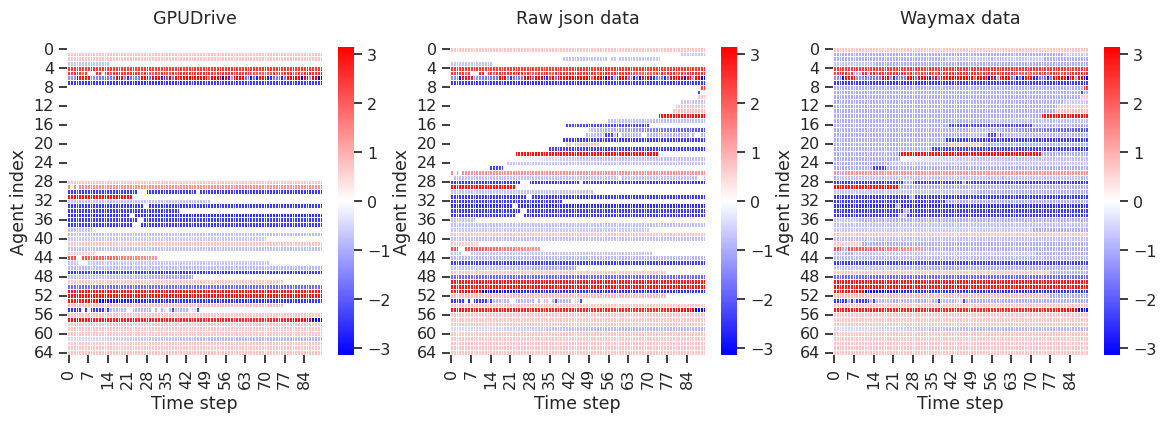

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=False, sharey=False)

# GPUDrive 
sns.heatmap(sim_yaw_xy[gpudrive_sorted_agent_idx.copy()][:TOTAL_AGENTS], cmap=CMAP, center=0, linewidth=.5, cbar=True, annot=False, ax=axs[0])
axs[0].set_title('GPUDrive', y=1.05)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Agent index')

# Raw json data 
sns.heatmap(json_yaws[gpudrive_sorted_agent_idx], cmap=CMAP, linewidth=.5, cbar=True, annot=False, ax=axs[1])
axs[1].set_title('Raw json data', y=1.05)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Agent index')

# Waymax VBD data 
sns.heatmap(waymax_scenario.log_trajectory.yaw[waymax_sorted_agent_idx][:TOTAL_AGENTS], cmap=CMAP, center=0, linewidth=.5, cbar=True, annot=False, ax=axs[2])
axs[2].set_title('Waymax data', y=1.05)
axs[2].set_ylabel('Agent index')
axs[2].set_xlabel('Time step');

### Velocities `x` and `y`


In [31]:
json_vel_x = []
json_vel_y = []

for obj in json_scenario['objects']:
    if 'velocity' in obj:
        json_vel_x.append([obj['velocity'][time_step]['x'] for time_step in range(TRAJ_LEN)])
        json_vel_y.append([obj['velocity'][time_step]['y'] for time_step in range(TRAJ_LEN)])
        
json_vel_y = np.array(json_vel_y)
json_vel_x = np.array(json_vel_x)

In [32]:
sim_vel_xy[:, :, 0].shape, json_vel_x.shape, 

(torch.Size([70, 91]), (65, 91))

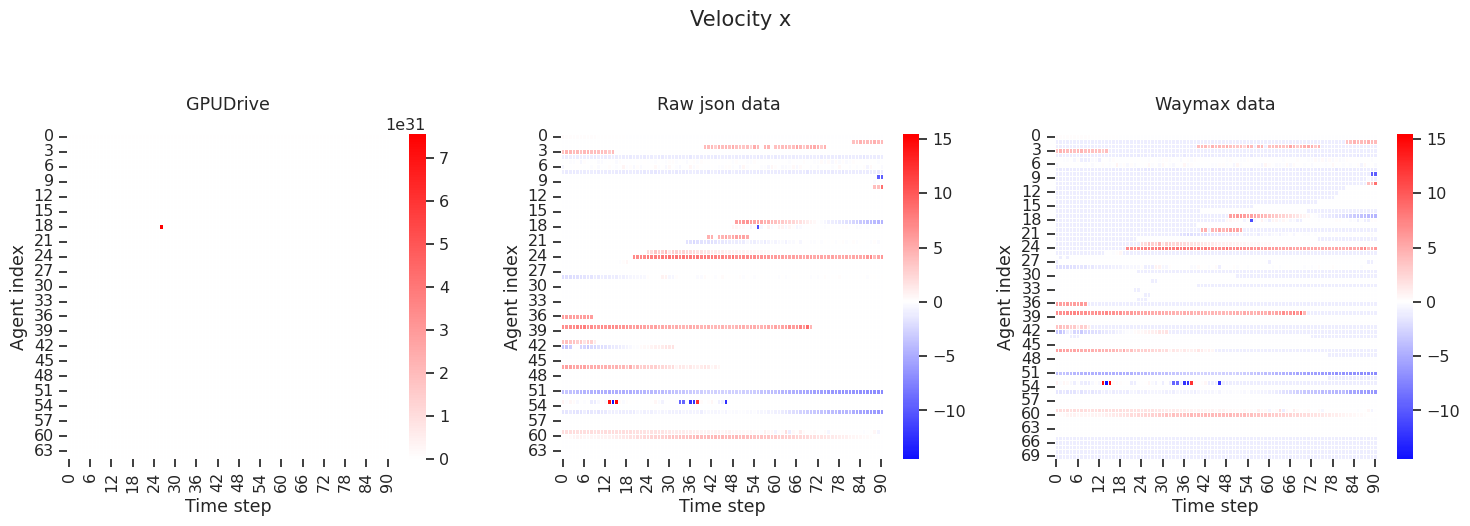

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)
fig.suptitle('Velocity x', y=1.05)

# GPUDrive (vel_x)
sns.heatmap(sim_vel_xy[:, :, 0][gpudrive_sorted_agent_idx.copy()], cmap=CMAP, center=0, linewidth=.5, cbar=True, annot=False, ax=axs[0])
axs[0].set_title('GPUDrive', y=1.05)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Agent index')

# Raw json data 
sns.heatmap(json_vel_x[gpudrive_sorted_agent_idx], center=0, cmap=CMAP,  linewidth=.5, cbar=True, annot=False, ax=axs[1])
axs[1].set_title('Raw json data ', y=1.05)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Agent index')

# Waymax VBD data 
sns.heatmap(waymax_scenario.log_trajectory.vel_x[waymax_sorted_agent_idx], center=0, cmap=CMAP, linewidth=.5, cbar=True, annot=False, ax=axs[2])
axs[2].set_title('Waymax data', y=1.05)
axs[2].set_ylabel('Agent index')
axs[2].set_xlabel('Time step')
plt.tight_layout()

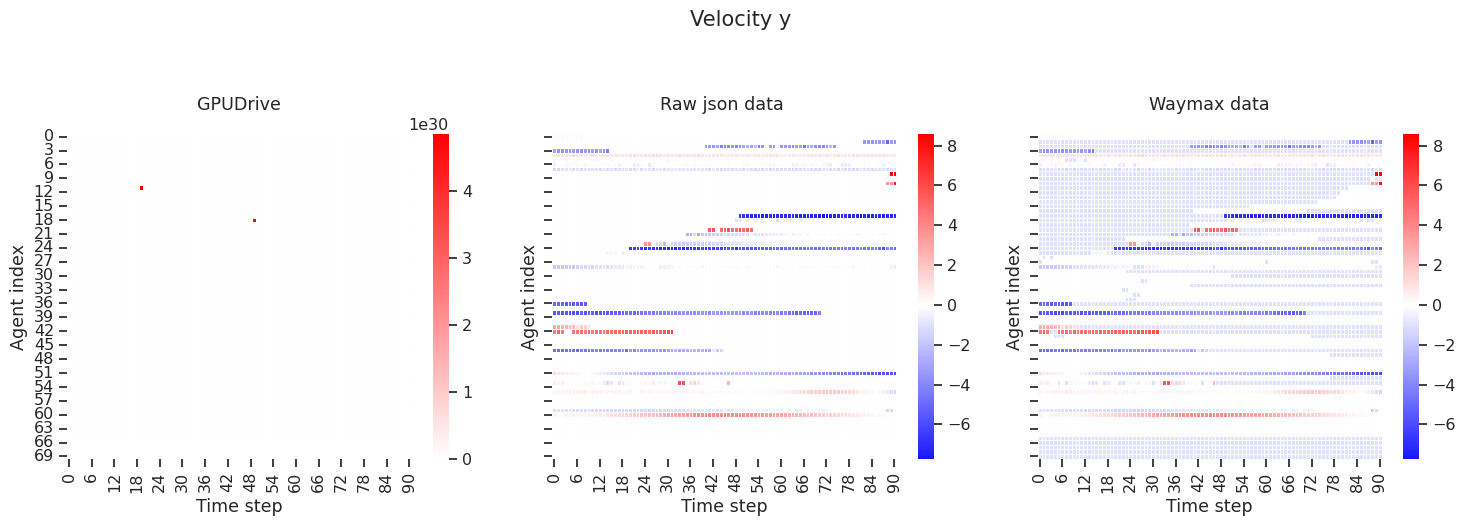

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

fig.suptitle('Velocity y', y=1.05)

# GPUDrive (vel_x)
sns.heatmap(sim_vel_xy[:, :, 1][:65, :][gpudrive_sorted_agent_idx.copy()], cmap=CMAP, center=0, linewidth=.5, cbar=True, annot=False, ax=axs[0])
axs[0].set_title('GPUDrive', y=1.05)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Agent index')

# Raw json data 
sns.heatmap(json_vel_y[gpudrive_sorted_agent_idx], cmap=CMAP, linewidth=.5, center=0, cbar=True, annot=False, ax=axs[1])
axs[1].set_title('Raw json data ', y=1.05)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Agent index')

# Waymax VBD data 
sns.heatmap(waymax_scenario.log_trajectory.vel_y[waymax_sorted_agent_idx], cmap=CMAP, center=0, linewidth=.5, cbar=True, annot=False, ax=axs[2])
axs[2].set_title('Waymax data', y=1.05)
axs[2].set_ylabel('Agent index')
axs[2].set_xlabel('Time step')
plt.tight_layout()

### Road points 


**Information**

- _Done_: Compare `x, y`
- _Todo_: Understand `dir_x`, `dir_y`

In [35]:
MAX_RPS = 10_000
MS = 0.5

# Road edges 
color_map = {
    int(MapElementIds.ROAD_EDGE_BOUNDARY): 'red',
    int(MapElementIds.ROAD_EDGE_MEDIAN): 'darkred',
    int(MapElementIds.DRIVEWAY): 'green',
}

marker_size_map = {
    int(MapElementIds.ROAD_EDGE_BOUNDARY): MS,
    int(MapElementIds.ROAD_EDGE_MEDIAN): MS,
    int(MapElementIds.DRIVEWAY): 3 * MS,
}

In [36]:
'''Waymax road graph information'''
way_roadgraph_points_x = np.asarray(waymax_scenario.roadgraph_points.x)
way_roadgraph_points_y = np.asarray(waymax_scenario.roadgraph_points.y)
way_roadgraph_points_types = np.asarray(waymax_scenario.roadgraph_points.types)
way_valid_roadgraph_points = np.asarray(waymax_scenario.roadgraph_points.valid)

way_roadgraph_points_dir_y.shape, way_valid_roadgraph_points.sum()

NameError: name 'way_roadgraph_points_dir_y' is not defined

In [37]:
'''json scenario road graph information'''
json_road_ids = []
json_road_points_x = []
json_road_points_y = []
json_road_points_dir_x = []
json_road_points_dir_y = []
json_road_points_types = []
json_road_points_valid = []

for road_idx, road in enumerate(json_scenario['roads']):
    for road_point_idx in range(len(json_scenario['roads'][road_idx]['geometry'])):
        json_road_ids.append(road['id']) # Append road id for each road point
        json_road_points_x.append(road['geometry'][road_point_idx]['x'])
        json_road_points_y.append(road['geometry'][road_point_idx]['y'])
        json_road_points_types.append(road['map_element_id']) # lane type
        #json_road_points_valid.append(road['geometry'][road_point_idx]['valid']) # NOTE: We don't store the valid flag, but I don't think we need it

# Convert to numpy arrays
json_road_ids = np.array(json_road_ids)
json_road_points_x = np.array(json_road_points_x)
json_road_points_y = np.array(json_road_points_y)
json_road_points_types = np.array(json_road_points_types)

json_road_points_x.shape

(13207,)

In [38]:
'''GPUDrive road graph information'''

# Road graph points
gpudrive_road_points_x = sim.map_observation_tensor().to_torch()[0, :, 0].numpy()
gpudrive_road_points_y = sim.map_observation_tensor().to_torch()[0, :, 1].numpy()
gpudrive_road_points_types = sim.map_observation_tensor().to_torch()[0, :, 8].numpy()

In [39]:
mask_road_edge_points = gpudrive_road_points_types == int(MapElementIds.ROAD_EDGE_BOUNDARY)
mask_road_median_points = gpudrive_road_points_types == int(MapElementIds.ROAD_EDGE_MEDIAN)
mask_road_driveway_points = gpudrive_road_points_types == int(MapElementIds.DRIVEWAY)

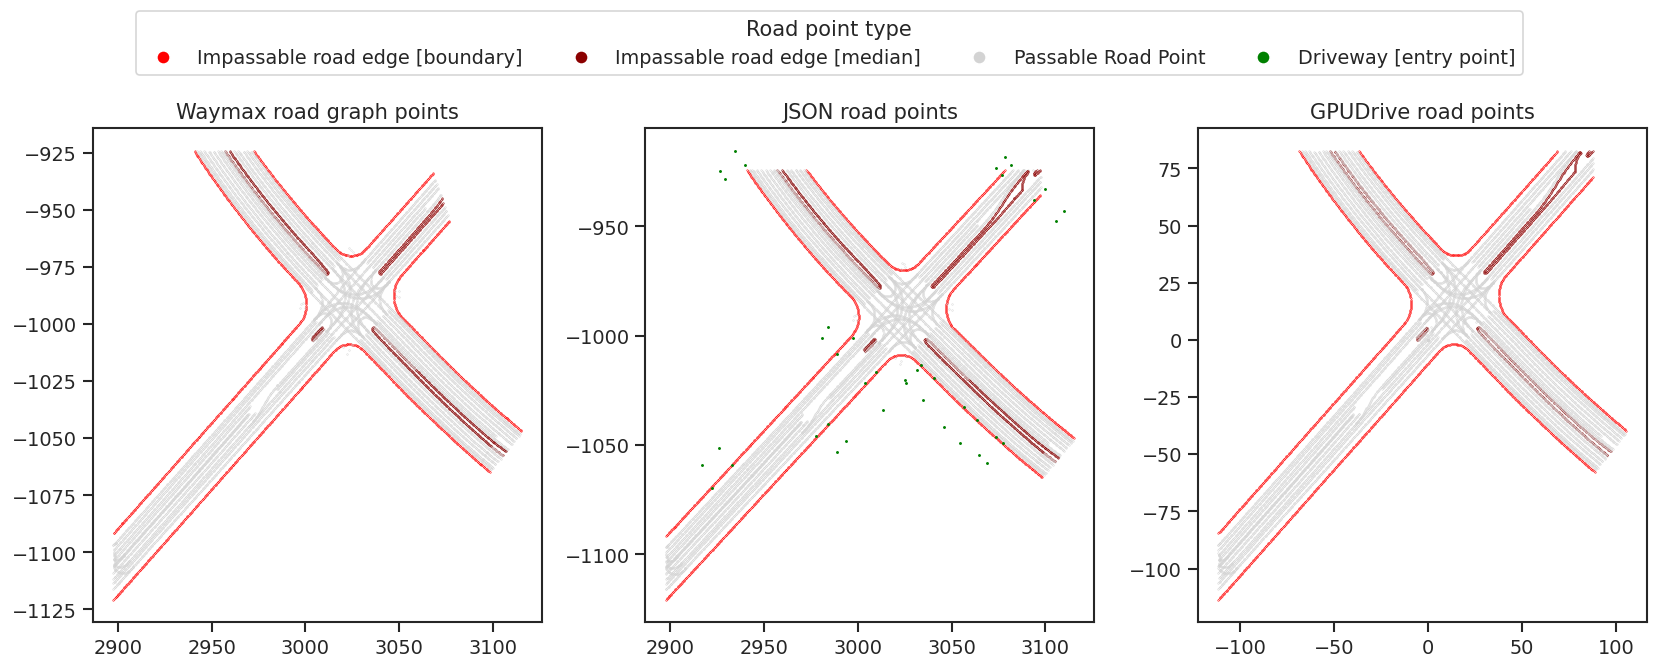

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5),  dpi=120, sharex=False, sharey=False)

# Plot waymax roadgraph points
axs[0].set_title('Waymax road graph points')
for idx in range(way_roadgraph_points_x.shape[0]):
    if way_valid_roadgraph_points[idx]:
        color = color_map[way_roadgraph_points_types[idx]] if way_roadgraph_points_types[idx] in color_map.keys() else 'lightgray'
        ms = marker_size_map[way_roadgraph_points_types[idx]] if way_roadgraph_points_types[idx] in marker_size_map.keys() else MS
        axs[0].plot(way_roadgraph_points_x[idx], way_roadgraph_points_y[idx], ".", color=color, markersize=ms)

# Plot JSON road points
axs[1].set_title('JSON road points')
for idx in range(json_road_points_x.shape[0]):
    color = color_map[json_road_points_types[idx]] if json_road_points_types[idx] in color_map.keys() else 'lightgray'
    ms = marker_size_map[json_road_points_types[idx]] if json_road_points_types[idx] in marker_size_map.keys() else MS
    axs[1].plot(json_road_points_x[idx], json_road_points_y[idx], ".", color=color, markersize=ms)

# Plot GPUDrive road points
axs[2].plot(gpudrive_road_points_x[mask_road_edge_points], gpudrive_road_points_y[mask_road_edge_points], ".", color=color_map[int(MapElementIds.ROAD_EDGE_BOUNDARY)], markersize=MS)
axs[2].plot(gpudrive_road_points_x[mask_road_median_points], gpudrive_road_points_y[mask_road_median_points], ".", color=color_map[int(MapElementIds.ROAD_EDGE_MEDIAN)], markersize=MS)
axs[2].plot(gpudrive_road_points_x[~mask_road_edge_points & ~mask_road_median_points], gpudrive_road_points_y[~mask_road_edge_points & ~mask_road_median_points], ".", color='lightgray', markersize=MS)
axs[2].plot(gpudrive_road_points_x[mask_road_driveway_points], gpudrive_road_points_y[mask_road_driveway_points], ".", color=color_map[int(MapElementIds.DRIVEWAY)], markersize=3*MS)

axs[2].set_title('GPUDrive road points')
# Define a shared legend for the figure
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[int(MapElementIds.ROAD_EDGE_BOUNDARY)], markersize=8, label='Impassable road edge [boundary]'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[int(MapElementIds.ROAD_EDGE_MEDIAN)], markersize=8, label='Impassable road edge [median]'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', markersize=8, label='Passable Road Point'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Driveway [entry point]')
]

fig.legend(handles=legend_elements, loc='upper center', ncol=4, title='Road point type', bbox_to_anchor=(0.5, 1.13))

plt.tight_layout();

#### `dir`

In [41]:
way_roadgraph_points_dir_x = np.asarray(waymax_scenario.roadgraph_points.dir_x)
way_roadgraph_points_dir_y = np.asarray(waymax_scenario.roadgraph_points.dir_y)

# They using this
heading = np.arctan2(way_roadgraph_points_dir_x, way_roadgraph_points_dir_y)

In [42]:
gpudrive_road_point_scale_len = sim.map_observation_tensor().to_torch()[:, :, 2].squeeze(0).numpy()
gpudrive_road_point_heading = sim.map_observation_tensor().to_torch()[:, :, 5].squeeze(0).numpy()

In [43]:
gpudrive_road_point_scale.shape, heading.shape

NameError: name 'gpudrive_road_point_scale' is not defined

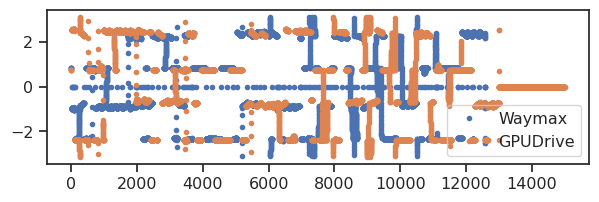

In [37]:
plt.plot(heading[way_valid_roadgraph_points], '.', label='Waymax');
plt.plot(gpudrive_road_point_heading, '.', label='GPUDrive')
plt.legend();

In [15]:
heading

array([ 0.82588035,  0.8258952 ,  0.82591254, ..., -2.3561945 ,
       -2.3561945 , -2.3561945 ], dtype=float32)

In [38]:
#waymax_scenario.roadgraph_points.ids[way_valid_roadgraph_points].shape
#waymax_scenario.roadgraph_points.ids[way_valid_roadgraph_points]

In [94]:
json_road_ids = np.array(json_road_ids)

json_road_ids.shape

(13207,)

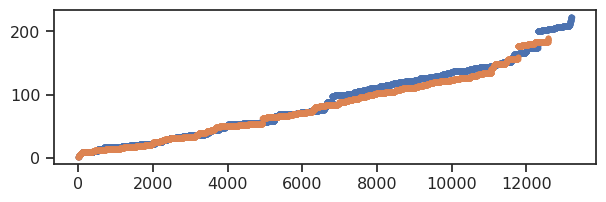

In [104]:
plt.plot(json_road_ids, '.' )
plt.plot(waymax_scenario.roadgraph_points.ids[way_valid_roadgraph_points], '.');

In [98]:
json_road_ids

array([  2,   2,   2, ..., 223, 223, 223])

In [37]:
way_roadgraph_points_dir_x = np.asarray(waymax_scenario.roadgraph_points.dir_x)
way_roadgraph_points_dir_y = np.asarray(waymax_scenario.roadgraph_points.dir_y)

# They using this
heading = np.arctan2(way_roadgraph_points_dir_x, way_roadgraph_points_dir_y)

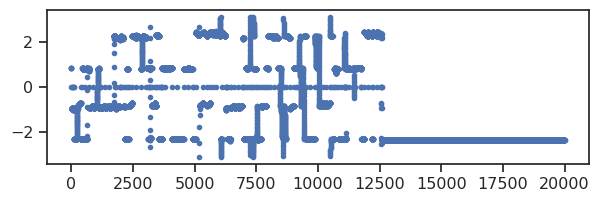

In [46]:
plt.plot(heading, '.')

In [50]:
way_roadgraph_points_dir_x

array([ 0.7351265,  0.7351365,  0.7351483, ..., -1.       , -1.       ,
       -1.       ], dtype=float32)

In [72]:
def rescale_to_range(data, min_val=0, max_val=10):
    data_min = np.min(data)
    data_max = np.max(data)
    # Rescale to [0, 1] then scale to [min_val, max_val]
    return min_val + (data - data_min) * (max_val - min_val) / (data_max - data_min)

# Apply rescaling
way_roadgraph_points_x = rescale_to_range(way_roadgraph_points_x)
way_roadgraph_points_y = rescale_to_range(way_roadgraph_points_y)


In [88]:
NUM_POINTS = 5

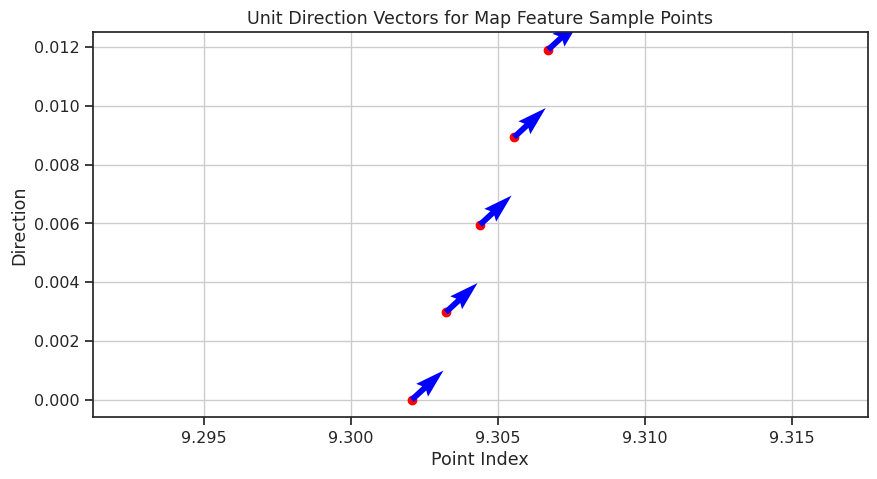

In [89]:
# Plot
plt.figure(figsize=(10, 5))
# Plot red dots for x, y points
plt.scatter(
    way_roadgraph_points_x[way_valid_roadgraph_points][:NUM_POINTS],
    way_roadgraph_points_y[way_valid_roadgraph_points][:NUM_POINTS],
    color='red', label='Points'
)

# Plot blue arrows for direction vectors
plt.quiver(
    way_roadgraph_points_x[way_valid_roadgraph_points][:NUM_POINTS], 
    way_roadgraph_points_y[way_valid_roadgraph_points][:NUM_POINTS], 
    way_roadgraph_points_dir_x[way_valid_roadgraph_points][:NUM_POINTS], 
    way_roadgraph_points_dir_y[way_valid_roadgraph_points][:NUM_POINTS], 
    color='blue', label='Direction Vectors'
)
plt.axis('equal')
plt.xlabel('Point Index')
plt.ylabel('Direction')
plt.title('Unit Direction Vectors for Map Feature Sample Points')
plt.grid()
plt.show()

### Process the road data